# Changing $p(x)$

The simplest case we consider is a linear trend in where we are sampling the data over time. For this, we have to make a slight change to how we generate the data since previously we were sampling $p(x|y)$ from Gaussian distributions, but now we will sample $p(x)$ independently, and then sample $p(y|x)$.

Perhaps generating x then p(y|x) does not make sense since our data is then no longer

In [1]:
import copy
import importlib
import numpy as np
import pandas as pd
import seaborn as sns
sns.set()
import matplotlib.pyplot as plt
import torch

import sklearn.linear_model as linear_model

from scipy.stats import pearsonr, spearmanr
from sklearn.metrics import confusion_matrix
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

import utils
importlib.reload(utils)
from utils import eval_model, perturb_labels_fp, update_model_feedback_linear_trend, update_model_feedback, make_trend_gaussian_data

%matplotlib inline

In [2]:
def train_update_loop(n_train, n_update, n_test, m0, m1, s0, s1, n_features, uniform_range, offset, seeds):
    seeds = np.arange(seeds)
    
    results = {"initial_orig_data_fprs": [], "initial_shifted_data_fprs": [], "updated_with_trend_on_orig_data_fprs": [], 
               "updated_with_trend_on_shifted_data_fprs": [], "updated_no_trend_on_orig_data_fprs": [], "updated_no_trend_on_shifted_data_fprs": []}

    for seed in seeds:
        np.random.seed(seed)

        x_train, y_train = make_trend_gaussian_data(m0, m1, s0, s1, n_train, n_features, uniform_range)
        x_update, y_update = make_trend_gaussian_data(m0, m1, s0, s1, n_update, n_features, uniform_range)
        x_test_orig, y_test_orig = make_trend_gaussian_data(m0, m1, s0, s1, n_test, n_features, uniform_range)
        x_test_shifted, y_test_shifted = make_trend_gaussian_data(m0, m1, s0, s1, n_test, n_features, [uniform_range[0] + offset, uniform_range[1]])

        model = linear_model.SGDClassifier(max_iter=10000, tol=1e-3, warm_start=True, loss="log")
        model.fit(x_train, y_train)

        y_pred = model.predict(x_test_orig)
        initial_orig_tnr, initial_orig_fpr, initial_orig_fnr, initial_orig_tpr = eval_model(y_test_orig, y_pred)

        y_pred = model.predict(x_test_shifted)
        initial_shifted_tnr, initial_shifted_fpr, initial_shifted_fnr, initial_shifted_tpr = eval_model(y_test_shifted, y_pred)

        new_model, _ = update_model_feedback(model, x_update, y_update, None, None, 100, intermediate=True)

        y_pred = new_model.predict(x_test_orig)
        updated_no_trend_orig_tnr, updated_no_trend_orig_fpr, updated_no_trend_orig_fnr, updated_no_trend_orig_tpr = eval_model(y_test_orig, y_pred)

        y_pred = new_model.predict(x_test_shifted)
        updated_no_trend_shifted_tnr, updated_no_trend_shifted_fpr, updated_no_trend_shifted_fnr, updated_no_trend_shifted_tpr = eval_model(y_test_shifted, y_pred)

        new_model = update_model_feedback_linear_trend(model, x_update, y_update, 100, offset)

        y_pred = new_model.predict(x_test_orig)
        updated_with_trend_orig_tnr, updated_with_trend_orig_fpr, updated_with_trend_orig_fnr, updated_with_trend_orig_tpr = eval_model(y_test_orig, y_pred)

        y_pred = new_model.predict(x_test_shifted)
        updated_with_trend_shifted_tnr, updated_with_trend_shifted_fpr, updated_with_trend_shifted_fnr, updated_with_trend_shifted_tpr = eval_model(y_test_shifted, y_pred)

        results["initial_orig_data_fprs"].append(initial_orig_fpr)
        results["initial_shifted_data_fprs"].append(initial_shifted_fpr)
        results["updated_no_trend_on_orig_data_fprs"].append(updated_no_trend_orig_fpr)
        results["updated_no_trend_on_shifted_data_fprs"].append(updated_no_trend_shifted_fpr)
        results["updated_with_trend_on_orig_data_fprs"].append(updated_with_trend_orig_fpr)
        results["updated_with_trend_on_shifted_data_fprs"].append(updated_with_trend_shifted_fpr)
        
    return results

In [9]:
def train_update_loop_temporal(n_train, n_update, n_test, num_updates, m0, m1, s0, s1, n_features, uniform_range, offset, seeds):
    seeds = np.arange(seeds)
    
    results = {"updated_with_trend_on_shifted_data_fprs": [], "updated_no_trend_on_shifted_data_fprs": []}

    for seed in seeds:
        np.random.seed(seed)
        print(seed)

        x_train, y_train = make_trend_gaussian_data(m0, m1, s0, s1, n_train, n_features, uniform_range)
        x_update, y_update = make_trend_gaussian_data(m0, m1, s0, s1, n_update, n_features, uniform_range)
        x_test_orig, y_test_orig = make_trend_gaussian_data(m0, m1, s0, s1, n_test, n_features, uniform_range)
        x_test_shifted, y_test_shifted = make_trend_gaussian_data(m0, m1, s0, s1, n_test, n_features, [uniform_range[0] + offset, uniform_range[1]])

        model = linear_model.SGDClassifier(max_iter=10000, tol=1e-3, warm_start=True, loss="log")
        model.fit(x_train, y_train)

        y_pred = model.predict(x_test_orig)
        initial_orig_tnr, initial_orig_fpr, initial_orig_fnr, initial_orig_tpr = eval_model(y_test_orig, y_pred)

        y_pred = model.predict(x_test_shifted)
        initial_shifted_tnr, initial_shifted_fpr, initial_shifted_fnr, initial_shifted_tpr = eval_model(y_test_shifted, y_pred)

        new_model, rates_updated_no_trend_evaluated_trend = update_model_feedback(model, x_update, y_update, x_test_shifted, y_test_shifted, num_updates, intermediate=True)

        new_model, rates_update_trend_evaluated_trend = update_model_feedback_linear_trend(model, x_update, y_update, x_test_shifted, y_test_shifted, num_updates, offset, intermediate=True)

        results["updated_no_trend_on_shifted_data_fprs"].append([initial_shifted_fpr] + rates_updated_no_trend_evaluated_trend["fpr"])
        results["updated_with_trend_on_shifted_data_fprs"].append([initial_shifted_fpr] + rates_update_trend_evaluated_trend["fpr"])
        
    return results

In [69]:
def results_to_dataframe_temporal(results, offset):
    data = {"type": [], "fpr": [], "num_updates": []}
    
    for t in results.keys():
        for i in range(len(results[t])):
            if t == "updated_no_trend_on_shifted_data_fprs":
                data["type"] += ["Updated Model\nwith $P_{\mathrm{update}}(x)$ \nTested on " + "$Q^{{ {} }}".format(offset) + "_{\mathrm{test}}(x)$"] * len(results[t][i])
            elif t == "updated_with_trend_on_shifted_data_fprs":
                data["type"] += ["Updated Model\nwith" +  "$Q^{{ {} }}".format(offset) + "_{\mathrm{update}}(x)$ \nTested on " + "$Q^{{ {} }}".format(offset) + "_{\mathrm{test}}(x)$"] * len(results[t][i])
            data["fpr"] += results[t][i]
            data["num_updates"] += np.arange(len(results[t][i])).tolist()
                
    return pd.DataFrame(data)

In [4]:
def results_to_dataframe(results):
    data = {"type": (["Initial Model \n Tested on $P_{\mathrm{test}}(x)$"] * len(results["initial_orig_data_fprs"])) + (["Initial Model \n Tested on $Q_{\mathrm{test}}(x)$"] * len(results["initial_shifted_data_fprs"])) + 
        (["Updated Model\n with $P_{\mathrm{update}}(x)$ \n Tested on $P_{\mathrm{test}}(x)$"] * len(results["updated_no_trend_on_orig_data_fprs"])) + 
        (["Updated Model\n with $P_{\mathrm{update}}(x)$ \n Tested on $Q_{\mathrm{test}}(x)$"] * len(results["updated_no_trend_on_shifted_data_fprs"])) +
        (["Updated Model\n with $Q_{\mathrm{update}}(x)$ \n Tested on $P_{\mathrm{test}}(x)$"] * len(results["updated_with_trend_on_orig_data_fprs"])) + 
        (["Updated Model\n with $Q_{\mathrm{update}}(x)$ \n Tested on $Q_{\mathrm{test}}(x)$"] * len(results["updated_with_trend_on_shifted_data_fprs"])), "fpr": results["initial_orig_data_fprs"] + 
        results["initial_shifted_data_fprs"] + results["updated_no_trend_on_orig_data_fprs"] + results["updated_no_trend_on_shifted_data_fprs"] + 
        results["updated_with_trend_on_orig_data_fprs"] + results["updated_with_trend_on_shifted_data_fprs"]}
    
    return pd.DataFrame(data)

## Linear Trend

In [34]:
m0 = -1
m1 = 1

s0 = 1
s1 = 1

n_train = 10000
n_update = 10000
n_test = 50000
n_features = 1
uniform_range = [-5, 5]
seeds = 100
num_updates = 100

### Positive

In [12]:
offset = 3.0

In [35]:
results_positive = train_update_loop_temporal(n_train, n_update, n_test, num_updates, m0, m1, s0, s1, n_features, uniform_range, offset, seeds)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


In [70]:
data_positive = results_to_dataframe_temporal(results_positive, "pos")

In [38]:
sns.set_style('white')

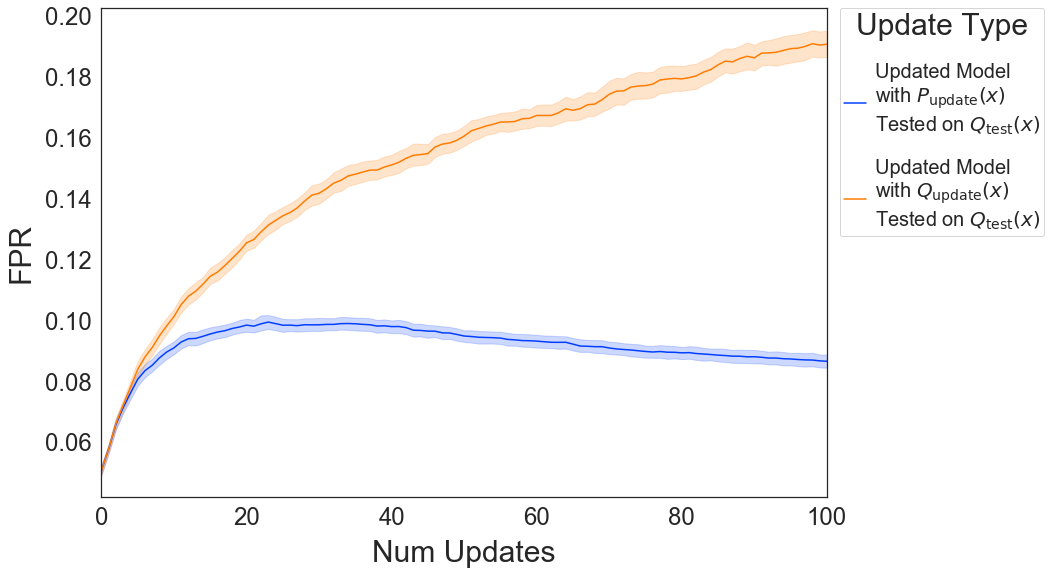

In [39]:
fig = plt.figure(figsize=(13,9))
# fig.suptitle("FPR vs Num Updates (fixed batch size)", fontsize=24)

ax = fig.add_subplot(111)


g = sns.lineplot(x="num_updates", y="fpr", hue="type", legend="full", data=data_positive, ax=ax, palette="bright")

ax.set_ylabel("FPR", fontsize=30, labelpad=10.0)
ax.set_xlabel("Num Updates", fontsize=30, labelpad=10.0)

ax.tick_params(axis='both', which='major', labelsize=24)
ax.tick_params(axis='both', which='minor', labelsize=24)

ax.set_xlim([0, num_updates])

# legend = g.legend(loc='upper right',  ncol=1, bbox_to_anchor=(1.22, 1), borderaxespad=0., prop={'size':14})

# plt.setp(legend.get_title(),fontsize='xx-small')

legend = ax.legend(title="Update Type", title_fontsize=30, labels=labels, loc="upper right", bbox_to_anchor=(1.3, 1), borderaxespad=0., labelspacing=2.0)
legend.texts[0].set_size(20)

fig.show()
# fig.savefig("figures/size_and_frequency/fpr_num_updates_temporal_gaussian.png", dpi=600)
# fig.savefig("figures/size_and_frequency/fpr_num_updates_temporal_gaussian.pdf")

### Negative

In [40]:
offset = -3.0

In [41]:
results_negative = train_update_loop_temporal(n_train, n_update, n_test, num_updates, m0, m1, s0, s1, n_features, uniform_range, offset, seeds)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


In [66]:
data_negative = results_to_dataframe_temporal(results_negative, "neg")

In [71]:
temp = pd.concat([data_positive, data_negative])

In [74]:
labels = ["Updated Model\nwith $P_{\mathrm{update}}(x)$ \nTested on $Q^{\mathrm{pos}}_{\mathrm{test}}(x)$"] + ["Updated Model\nwith $Q^{\mathrm{pos}}_{\mathrm{update}}(x)$ \nTested on $Q^{\mathrm{pos}}_{\mathrm{test}}(x)$"] + ["Updated Model\nwith $P_{\mathrm{update}}(x)$ \nTested on $Q^{\mathrm{neg}}_{\mathrm{test}}(x)$"] + ["Updated Model\nwith $Q^{\mathrm{neg}}_{\mathrm{update}}(x)$ \nTested on $Q^{\mathrm{neg}}_{\mathrm{test}}(x)$"]

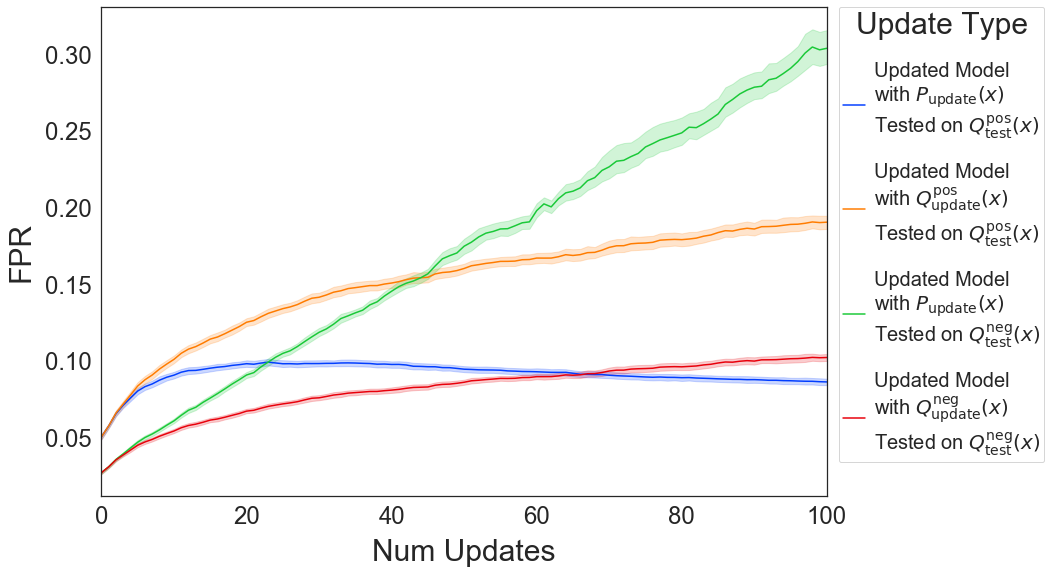

In [81]:
fig = plt.figure(figsize=(13,9))
# fig.suptitle("FPR vs Num Updates (fixed batch size)", fontsize=24)

ax = fig.add_subplot(111)


g = sns.lineplot(x="num_updates", y="fpr", hue="type", legend="full", data=temp, ax=ax, palette="bright")

ax.set_ylabel("FPR", fontsize=30, labelpad=10.0)
ax.set_xlabel("Num Updates", fontsize=30, labelpad=10.0)

ax.tick_params(axis='both', which='major', labelsize=24)
ax.tick_params(axis='both', which='minor', labelsize=24)

ax.set_xlim([0, num_updates])

# legend = g.legend(loc='upper right',  ncol=1, bbox_to_anchor=(1.22, 1), borderaxespad=0., prop={'size':14})

# plt.setp(legend.get_title(),fontsize='xx-small')

legend = ax.legend(title="Update Type", title_fontsize=30, loc="upper right", labels=labels, bbox_to_anchor=(1.3, 1), borderaxespad=0., labelspacing=2.0)
legend.texts[0].set_size(20)

fig.show()
fig.savefig("figures/changing_px/linear_trend.png", bbox_extra_artists=(legend,),  bbox_inches='tight', dpi=600)
fig.savefig("figures/changing_px/linear_trend.pdf", bbox_extra_artists=(legend,),  bbox_inches='tight')

In [57]:
"$Q^{{}}".format("neg")

'$Q^{}'